In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import json

In [2]:
# label_folder = r'D:\Competitions\ComputerVision\OCR\Signalboard\dataset\train\label\custom'
# image_folder = r'D:\Competitions\ComputerVision\OCR\Signalboard\dataset\train\image\official'

label_folder = r'C:\Users\Atlas\Desktop\Sinalboard_OCR\dataset\train\label\custom'
image_folder = r'C:\Users\Atlas\Desktop\Sinalboard_OCR\dataset\train\image\official'

In [14]:
def create_1D_centerness(s,S,e,E):
    m = (s+e)/2
    M = int(m)
    rep = np.concatenate([np.arange(S+1,M+1),np.array([m]),np.arange(M+1,E+1)])
    
    line = np.fmin(rep-s,e-rep)/np.fmax(rep-s,e-rep)
    return line
    
# def get_centerness_patch_and_loc(ltwh,map_size):
#     l,t,w,h = ltwh*map_size
    
#     r = l+w
#     b = t+h
    
#     L = int(l)
#     T = int(t)
#     R = int(r)
#     B = int(b)
    
#     hor = create_1D_centerness(l,L,r,R)
#     ver = create_1D_centerness(t,T,b,B)
    
#     patch = np.sqrt(hor*ver[:,None])
#     return L,R,T,B,patch

def get_patches_and_loc(ltwh,map_size):
    l,t,w,h = ltwh*map_size
    
    r = l+w
    b = t+h
    
    L = int(l)
    T = int(t)
    R = int(r)
    B = int(b)
    
    centerness_hor = create_1D_centerness(l,L,r,R)
    centerness_ver = create_1D_centerness(t,T,b,B)
    centerness_patch = np.sqrt(centerness_hor*centerness_ver[:,None])
    
    
    grid_center_coor = np.stack(np.broadcast_arrays((np.arange(L,R+1)+0.5),(np.arange(T,B+1)+0.5)[:,None]),axis=-1)/map_size
    grid_center_coor = grid_center_coor[:,:,None,:]
    bbox_rect_coor = np.array([[l,t],[r,t],[r,b],[l,b]])/map_size
    bbox_rect_coor = bbox_rect_coor[None,None,:,:]
    determine_patch = np.max(np.abs(grid_center_coor-bbox_rect_coor),axis=-1)
    determine_patch = np.max(determine_patch,axis=-1)
    
    return L,R,T,B,centerness_patch,determine_patch

In [23]:
label_id = 2908
label_path = pathlib.Path(label_folder,f'img_{label_id}.json')
label = json.loads(label_path.read_text(encoding='utf8'))
image_byte = tf.io.read_file(pathlib.Path(image_folder,label['ImageName']).as_posix())
image = tf.image.decode_jpeg(image_byte)
image = tf.image.convert_image_dtype(image,tf.float32)
image = tf.image.resize(image,(1024,1024))

image_size = 1024
map_size = 128
determine_range = [16,32,64,128,256,512,1024]


determine_range = [d/image_size for d in determine_range]
determine_range = [(determine_range[i-1]+1,d) if i != 0 else (0,d) for i,d in enumerate(determine_range)]

ltwh_stack = np.array([b['rectangle']['ltwh'] for b in label['bboxes']])
ltwh_stack[:,2:] = ltwh_stack[:,2:]-1e-4

centerness = [np.zeros((map_size,map_size)) for _ in range(len(determine_range))]
gt_center = [np.zeros((map_size,map_size)) for _ in range(len(determine_range))]

for ltwh in ltwh_stack:
    L, R, T, B, centerness_patch, determine_patch = get_patches_and_loc(ltwh, map_size)
    print(determine_patch)
    for i,dr in enumerate(determine_range):
        mask = (dr[0]<=determine_patch)&(determine_patch<=dr[1])
        centerness[i][T:B+1,L:R+1] = np.where(
            (centerness_patch>centerness[i][T:B+1,L:R+1])&mask,
            centerness_patch,
            centerness[i][T:B+1,L:R+1])
    
#     bbox_loc[T:B+1,L:R+1,:] = np.concatenate([center,ltwh[2:]],axis=-1)
#     bbox_loc_stack.append(bbox_loc)
    
#     centerness[T:B+1,L:R+1] = patch
#     centerness_stack.append(centerness)
    
#     gt_center[int(cy),int(cx)] = 1.

# bbox_loc_stack = np.stack(bbox_loc_stack,axis=0)
# centerness_stack = np.stack(centerness_stack,axis=0)

# gt_center = np.zeros((map_size,map_size))
# gt_center[(center_stack[:,1]*map_size).astype(int),(center_stack[:,0]*map_size).astype(int)] = 1.

# centerness = np.max(centerness_stack,axis=0)

# plt.figure(figsize=(20,20))
# plt.imshow(centerness)
# plt.show()
# plt.figure(figsize=(20,20))
# plt.imshow(image)
# plt.show()

[[0.1014625  0.09365    0.0858375  0.078025   0.0702125  0.0624
  0.0545875  0.05761719 0.06542969 0.07324219 0.08105469 0.08886719
  0.09667969 0.10449219]
 [0.1014625  0.09365    0.0858375  0.078025   0.0702125  0.0624
  0.0545875  0.05761719 0.06542969 0.07324219 0.08105469 0.08886719
  0.09667969 0.10449219]
 [0.1014625  0.09365    0.0858375  0.078025   0.0702125  0.0624
  0.0545875  0.05761719 0.06542969 0.07324219 0.08105469 0.08886719
  0.09667969 0.10449219]
 [0.1014625  0.09365    0.0858375  0.078025   0.0702125  0.0624
  0.0545875  0.05761719 0.06542969 0.07324219 0.08105469 0.08886719
  0.09667969 0.10449219]]
[[0.12685313 0.11904063 0.11122813 0.10341563 0.09560313 0.08779063
  0.07997813 0.07216563 0.06435313 0.06835938 0.07617188 0.08398438
  0.09179688 0.09960938 0.10742188 0.11523438 0.12304688]
 [0.12685313 0.11904063 0.11122813 0.10341563 0.09560313 0.08779063
  0.07997813 0.07216563 0.06435313 0.06835938 0.07617188 0.08398438
  0.09179688 0.09960938 0.10742188 0.1152

 [0.02431406 0.01679542 0.01679542 0.02050781]]
[[0.02040781 0.01657344 0.01657344 0.0234375 ]
 [0.02040781 0.01259531 0.015625   0.0234375 ]
 [0.02040781 0.01753892 0.01753892 0.0234375 ]]
[[0.01845469 0.01508645 0.01855469]
 [0.01845469 0.01074219 0.01855469]
 [0.01845469 0.01828241 0.01855469]]
[[0.02138438 0.01508645 0.01508645 0.02148438]
 [0.02138438 0.01357188 0.01367188 0.02148438]
 [0.02138438 0.01828241 0.01828241 0.02148438]]
[[0.02626719 0.02436271 0.02436271 0.02734375]
 [0.02626719 0.01845469 0.01953125 0.02734375]
 [0.02626719 0.01845469 0.01953125 0.02734375]
 [0.02626719 0.02276661 0.02276661 0.02734375]]
[[0.02919688 0.02361921 0.02361921 0.02441406 0.03222656]
 [0.02919688 0.02138438 0.01660156 0.02441406 0.03222656]
 [0.02919688 0.02138438 0.01660156 0.02441406 0.03222656]
 [0.02919688 0.02351011 0.02351011 0.02441406 0.03222656]]
[[0.03407969 0.02626719 0.02287572 0.02287572 0.02832031]
 [0.03407969 0.02626719 0.01845469 0.02050781 0.02832031]
 [0.03407969 0.026267

In [24]:
determine_range

[(0, 0.015625),
 (1.015625, 0.03125),
 (1.03125, 0.0625),
 (1.0625, 0.125),
 (1.125, 0.25),
 (1.25, 0.5),
 (1.5, 1.0)]

In [25]:
determine_range = [16,32,64,128,256,512,1024]


determine_range = [d/image_size for d in determine_range]
# determine_range = [(determine_range[i-1]+1,d) if i != 0 else (0,d) for i,d in enumerate(determine_range)]
determine_range

[0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0]

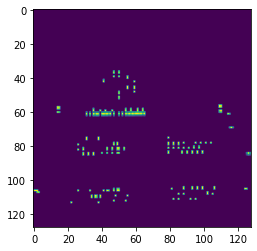

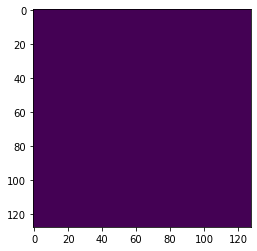

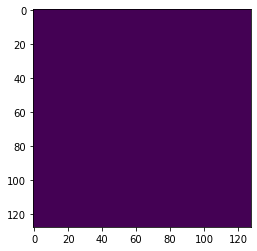

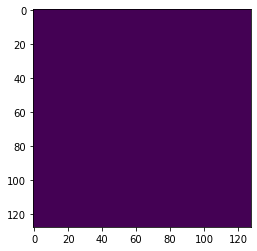

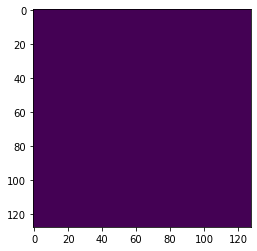

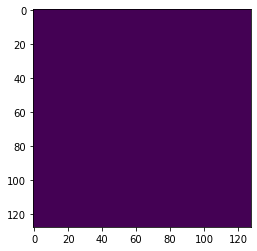

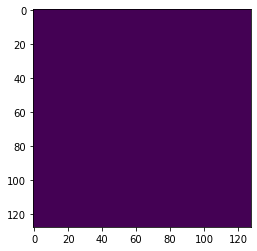

In [22]:
for c in centerness:
    plt.imshow(c)
    plt.show()

In [ ]:
centerness_patch
determin_patch

In [ ]:
[centerness,gt_center,normalized_dx,normalized_dy,w,h]